# Sampling rate for Face Detection

All videos were downloaded at 30 FPS. Using this frame rate for detection gives us a 3:1 speedup from real time. Considering the large amount of footage required to process, further speedup is required. Another improvement is related to a smooth transition between frames. A phenomenon called jittering.

In [7]:
%matplotlib inline
import json
from datetime import timedelta
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

video_samples = [{'folder': r'../data/tracks@30FPS', 'label': '30FPS'}]

for video_sample in video_samples:
    video_sample['files'] = list(Path(video_sample['folder']).glob('*.tracks.json'))
    
    #video_sample['data'] = []
    video_sample['tracks'] = []
    
    video_sample['widths'] = []
    video_sample['heights'] = []
    
    video_sample['track_duration'] = []
    video_sample['footage_duration'] = []
    video_sample['detection_duration'] = []
    
    for i, track_file in enumerate(video_sample['files']):
        with track_file.open('r', encoding='utf8') as fp:
            video = json.load(fp)
        
        # video_sample['data'].append(video)
        video_sample['widths'].append(video['width'])
        video_sample['heights'].append(video['height'])
        video_sample['footage_duration'].append(video['video_duration'])
        video_sample['detection_duration'].append(video['detection_duration'])

        for track in video['tracks'].values():
            track['parent_video_idx'] = i
            video_sample['tracks'].append(track)
            video_sample['track_duration'].append(track['end_time'] - track['start_time'])
    
    video_sample['num_files'] = len(video_sample['files'])
    video_sample['num_tracks'] = len(video_sample['tracks'])
    
    video_sample['total_track_duration'] = sum(video_sample['track_duration'])
    video_sample['total_footage_duration'] = sum(video_sample['footage_duration'])
    video_sample['total_detection_duration'] = sum(video_sample['detection_duration'])
    
    video_sample['td_total_track_duration'] = timedelta(seconds=video_sample['total_track_duration'])
    video_sample['td_total_footage_duration'] = timedelta(seconds=video_sample['total_footage_duration'])
    video_sample['td_total_detection_duration'] = timedelta(seconds=video_sample['total_detection_duration'])
    
    video_sample['widths'] = np.float32(video_sample['widths'])
    video_sample['heights'] = np.float32(video_sample['heights'])
    video_sample['track_duration'] = np.float32(video_sample['track_duration'])
    video_sample['footage_duration'] = np.float32(video_sample['footage_duration'])
    video_sample['detection_duration'] = np.float32(video_sample['detection_duration'])
    
    video_sample['areas'] = video_sample['widths'] * video_sample['heights']
    video_sample['speedup'] = video_sample['footage_duration'] / video_sample['detection_duration']
    
    print("""{label}:
    - Number of Files:  {num_files}
    - Number of Tracks: {num_tracks}
    - Footage length:   {td_total_footage_duration}
    - Detection length: {td_total_detection_duration}
    - Track length:     {td_total_track_duration}""".format_map(video_sample))

30FPS:
    - Number of Files:  36
    - Number of Tracks: 959
    - Footage length:   12:10:29.802150
    - Detection length: 6:53:36.965992
    - Track length:     9:30:40.905744


We take a random sample of videos from the dataset. From these we take 5 second segments of detected bounding boxes. The 30 FPS samples will be our ground truth while subsamples of 15, 7, and 3FPS will be used as contrast. We will use the signal to noise ratio to check on the quality of the signals. We will use interpolation estrategies to complete the missing gaps in detection.

## Speedup by lowering frame rate

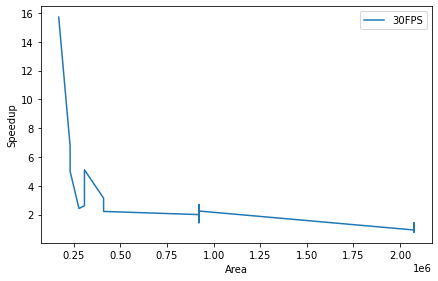

In [8]:
fig = plt.figure()
ax = plt.axes()

for video_sample in video_samples:
    area = np.float32(video_sample['areas'])
    speedup = np.float32(video_sample['speedup'])
    
    # Order results by area
    idx = np.argsort(area)
    area = area[idx]
    speedup = speedup[idx]
    
    ax.plot(area, speedup, label=video_sample['label'])

fig.tight_layout()
plt.xlabel('Area')
plt.ylabel('Speedup')
plt.legend()
plt.show()

# TODO: Linegraph Area vs Speedup with Frame Rate as color categories.

## Interpolation Methods

We try several interpolation methods and check the quality of the signal using the signal to noise ratio.
Will compute the time-normalized difference on consecutive detected centroids, widht and height.

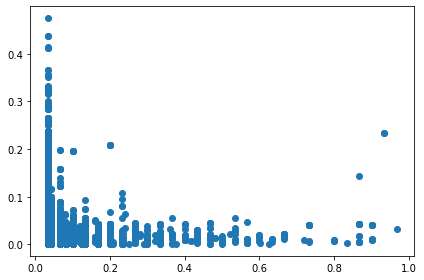

In [46]:
SAMPLE_LENGTH = 5.0
SAMPLE_NUM = 1000

np.random.seed(0)

fig = plt.figure()
ax = plt.axes()

for video_sample in video_samples:
    sample = np.random.random((SAMPLE_NUM, 2))
    sample_track = np.floor(sample[:, 0] * video_sample['num_tracks']).astype(int)
    
    times = []
    delta_size = []
    delta_center = []
    
    for i in sample_track:
        track_data = video_sample['tracks'][i]
        parent_video_idx = track_data['parent_video_idx']
        
        track_times = []
        track_bboxes = []
        
        track_length = ((track_data['end_time'] - SAMPLE_LENGTH) - track_data['start_time'])
        stime = track_data['start_time'] + sample[i, 1] * track_length
        
        for frame in track_data['data']:
            if stime <= frame['time'] < stime + SAMPLE_LENGTH:
                track_times.append(frame['time'])
                track_bboxes.append(frame['bbox'])
        
        track_times = np.float32(track_times)
        track_bboxes = np.float32(track_bboxes).reshape((-1, 2, 2))
        
        # Normalize bbox w/r to image size
        track_bboxes[:, :, 0] /= video_sample['widths'][parent_video_idx]
        track_bboxes[:, :, 1] /= video_sample['heights'][parent_video_idx]
        
        track_width = track_bboxes[:, 1, 0] - track_bboxes[:, 0, 0]
        track_height = track_bboxes[:, 1, 1] - track_bboxes[:, 0, 1]
        track_center_x = track_bboxes[:, 0, 0] + 0.5 * track_width
        track_center_y = track_bboxes[:, 0, 1] + 0.5 * track_height
        
        track_delta_times = track_times[1:] - track_times[:-1]
        track_delta_size = np.sqrt((track_width[1:] - track_width[:-1])**2 + (track_height[1:] - track_height[:-1])**2)
        track_delta_center = np.sqrt((track_center_x[1:] - track_center_x[:-1])**2 + (track_center_y[1:] - track_center_y[:-1])**2)
        
        times.append(track_delta_times)
        delta_size.append(track_delta_size)
        delta_center.append(track_delta_center)
    
    times = np.concatenate(times)
    delta_size = np.concatenate(delta_size)
    delta_center = np.concatenate(delta_center)
    
    idx = np.argsort(times)
    
    times = times[idx]
    delta_size = delta_size[idx]
    delta_center = delta_center[idx]
    
    ax.scatter(times, delta_size, label=video_sample['label'])
    # How much the center moves
    # How much the width changes (Normalized by image width)
    # How mch the height changes (Normalized by image height)

fig.tight_layout()
plt.show()